# Predicting Bike Rentals


#### Darren Ho

## Introduction

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is on those cities. The District collects detailed data on the number of bicycles people rent by the hour and day. 

The data we will be working with contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The dataset can be downloaded from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In this project, we'll try to predict the total number of bikes people rented in a given hour. We will predict the `cnt` column, which represents the total number of bike rentals, using all of the other columns, except for `casual` and `registered`.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
bike_rentals.shape

print('Number of rows:', bike_rentals.shape[0])
print('Number of columns:', bike_rentals.shape[1])

Number of rows: 17379
Number of columns: 17


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

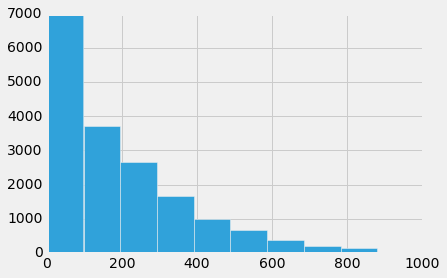

In [4]:
plt.style.use('fivethirtyeight')
plt.hist(bike_rentals['cnt'])

In [5]:
bike_rentals.corr()["cnt"].sort_values(ascending=False)[1:]

registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

We see that the distribution of `cnt` values, or total rentals, is right-skewed. We also use the `corr` method to explore how each column is correlated with `cnt`. We find that `registered` has the strongest correlation with `cnt` at approximately 0.97, whereas `weekday` has the weakest correlation with `cnt` at about 0.027. `hum` has the strong negative correlation with `cnt` at approximately -0.323.    

## Calculating Features

The `hr` column in our `bike_rentals` dataset contains the hours during which bikes are rented, from `1` to `24`. We will bundle similar times together, enabling the model to make better decisions. 

In [6]:
def assign_label(hour):
    
    if hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour < 24:
        return 3
    else:
        return 4

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Splitting the Data Into Train and Test Sets

We need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. 

In [7]:
# training set - 80% of rows in df to be part of training set

train = bike_rentals.sample(frac=0.8)


# testing set - any rows that arent in training set
# bike_rentals.index.isin(train.index) generates boolean series
# bike_rentals.loc[~bike_rentals.index.isin(train.index)] selects any rows that arent found in train
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Applying Linear Regression

Now that we've done some exploration and manipulation, we are ready to apply linear regression to the data. We picked the error metric: Mean Squared Error - to evaluate the performance of the ML algorithms. 

In [8]:
# creating list of predictor columns to use in training and predictions

features = list(bike_rentals.columns.drop(['cnt', 'casual', 'dteday', 'registered']))
features

['instant',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

In [9]:
# Setting up linear regression on `train` and make predictions on `test`
lr = LinearRegression()
lr.fit(train[features], train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
predictions = lr.predict(test[features])

# calc error btwn predictions and actual values 

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 17566.31


We created a list of predictor columns that excluded the `cnt`, `casual`, `dteday` and `registered` columns. We then ran a linear regression on `train` and then made predictions on `test`. Finally, we calculated the MSE, in which we got 17566.31.  

## Applying Decision Trees

Now we're ready to apply the decision tree algorithm. We'll be able to compare the decision tree algorithm error with the error from the linear regression, which will allow us to pick the right algorithm for the dataset.  

In [11]:
# Setting up Decision Tree algorithm on `train` and make predictions on `test`

reg = DecisionTreeRegressor(random_state=1)
reg.fit(train[features], train['cnt'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [12]:
predictions = reg.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 3198.63


In [13]:
# experimenting with various parameters of the DecisionTreeRegressor class
# min_sample_leaf = 5

reg = DecisionTreeRegressor(random_state=1, min_samples_leaf=5)
reg.fit(train[features], train['cnt'])

predictions = reg.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 2599.98


In [14]:
# experimenting with various parameters of the DecisionTreeRegressor class
# min_sample_leaf = 10

reg = DecisionTreeRegressor(random_state=1, min_samples_leaf=10)
reg.fit(train[features], train['cnt'])

predictions = reg.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 2739.65


In [15]:
# experimenting with various parameters of the DecisionTreeRegressor class
# max_depth = 10

reg = DecisionTreeRegressor(random_state=1, max_depth = 10)
reg.fit(train[features], train['cnt'])

predictions = reg.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 3532.09


In [16]:
# experimenting with various parameters of the DecisionTreeRegressor class
# max_depth = 20

reg = DecisionTreeRegressor(random_state=1, max_depth = 20)
reg.fit(train[features], train['cnt'])

predictions = reg.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 3294.27


Right off the bat, we see that the Decision tree algorithm with default parameters has a MSE value of 3206.02, which is significantly less than the MSE value we got from the linear regression we ran earlier. 

We then experimented with various parameters, starting off with the `min_samples_leaf` parameter. By changing the parameter from its default value of `1` to `5` and `10`, we further decrease the MSE values down to 2551.15 and 2609.62, respectively.  

We then experimented with the `max_depth` paramter by changing its values to `10` and `20`. We see that as `max_depth` increases, MSE decreases slightly.   

## Applying Random Forests

We can now apply the random forest algorithm, which improves on the decision tree algorithm. 

In [17]:
# Setting up Random Forest algorithm on `train` and make predictions on `test`

reg = RandomForestRegressor()
reg.fit(train[features], train['cnt'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [18]:
predictions = reg.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 1927.24


In [19]:
# experimenting with various parameters of the RandomForestRegressor class
# min_sample_leaf = 5

reg = RandomForestRegressor(random_state=1, min_samples_leaf=5)
reg.fit(train[features], train['cnt'])

predictions = reg.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 2053.81


In [20]:
# experimenting with various parameters of the RandomForestRegressor class
# min_sample_leaf = 10

reg = RandomForestRegressor(random_state=1, min_samples_leaf=10)
reg.fit(train[features], train['cnt'])

predictions = reg.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 2396.09


In [21]:
# experimenting with various parameters of the RandomForestRegressor class
# max_depth = 10

reg = RandomForestRegressor(random_state=1, max_depth = 10)
reg.fit(train[features], train['cnt'])

predictions = reg.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 2727.2


In [22]:
# experimenting with various parameters of the RandomForestRegressor class
# max_depth = 20

reg = RandomForestRegressor(random_state=1, max_depth = 20)
reg.fit(train[features], train['cnt'])

predictions = reg.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 1930.82


Random forests tend to be more accurate than simple models like linear regression, and is proven here as our random forest with default parameters returns a MSE value of 1805.58. Random forests are prone to overfitting, so it was important to tune parameters like minimum samples per leaf and maximum depth.

Starting with `min_samples_leaf`, we changed the default value to `5` and `10`. Unlike the Decision tree algorithm, the MSE values actually increased this time around.  

With the `max_depth` parameter, we changed the default value to `10` and `20`. The MSE values seem to decrease as `max_depth` increases. However, both respective MSE values are greater than the original MSE value of the Random Forest.  

## Conclusion

Of the three ML algorithms, Linear Regression performed the worst as it had significantly more MSE. Decision Trees and Random Forests are better options than Linear Regression, with Random Forests performing the best of the bunch. 

Both decision trees and random forests tend to be much more accurate than simple models like linear regression. However, decision trees and random forests tend to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf.  

## Next Steps

Potential Next Steps to improve this project: 

- Calculate additional features, such as:
    - An index combining temperature, humidity, and wind speed
- Predict `casual` and `registered` instead of `cnt`